In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import pyEulerCurves as pyecc

In [2]:
def pad_image(image, value):
    return np.pad(image, ((1, 1), (1,1), (0,0)), constant_values=value)

In [7]:
def compute_contributions(image, inf_value=256):
    # pad image
    image = pad_image(image, inf_value)
    
    # compute contributions of all cells, 
    # starting from bottom left
    # uses lowert star filtration
    
    contributions = dict()
    
    for i in range(1, image.shape[0]):
        for j in range(1, image.shape[1]):
            # lets track all the contributions
            # from cell i,j
                        
            # itself, 2d cell
            f = tuple(image[i,j])
            contributions[f] = contributions.get(f, 0) + 1
                        
            # 0d cell SW
            f = tuple(np.fmin(image[i,j], 
                              np.fmin(image[i-1,j-1],
                                      np.fmin(image[i-1,j],
                                              image[i,j-1])
                                     )
                             )
                     )   
            contributions[f] = contributions.get(f, 0) + 1
            
            # 1d cell W
            f = tuple(np.fmin(image[i,j], image[i,j-1]))
            contributions[f] = contributions.get(f, 0) - 1
            
            # 1d cell S
            f = tuple(np.fmin(image[i,j], image[i-1,j]))
            contributions[f] = contributions.get(f, 0) - 1
                        
    # remove contributions at infinity
    infinity = tuple(np.array([inf_value for i in range(image.shape[-1])]))
    del contributions[infinity]
    
    # remove the contributions that are 0
    to_del = []
    for key in contributions:
        if contributions[key] == 0:
            to_del.append(key)
    for key in to_del:
        del contributions[key]

    return sorted(list(contributions.items()), key=lambda x: x[0])

# Load a grayscale image
# compute 1d ECC

(500, 1000, 1)


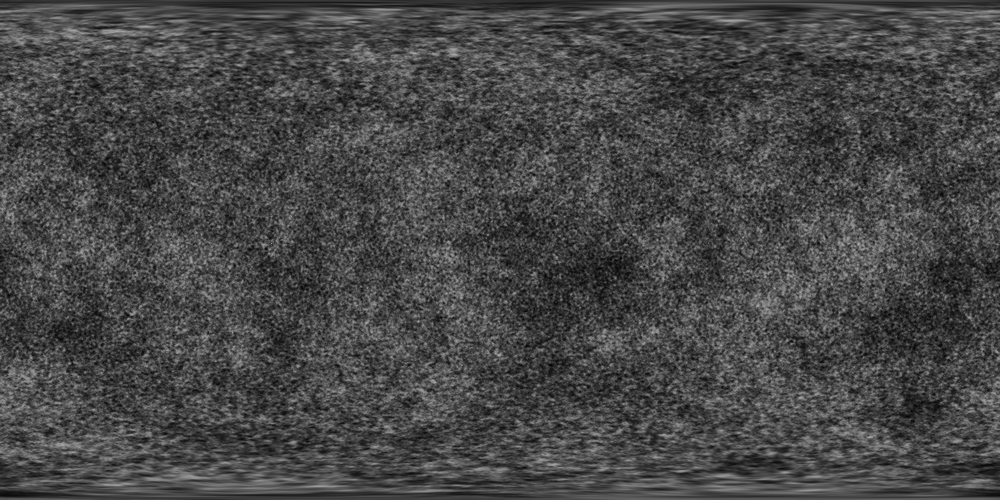

In [8]:
image_plank = Image.open("data/Planck.png")

plank_np = np.int16(image_plank)

plank_np_expanded = np.expand_dims(plank_np, axis=2)

print(plank_np_expanded.shape)
image_plank

In [9]:
# given the ordered list of local contributions
# returns a list of tuples (filtration, euler characteristic)
def euler_characteristic_list_from_all(local_contributions):

    euler_characteristic = []
    old_f, current_characteristic = local_contributions[0]

    for filtration, contribution in local_contributions[1:]:
        if filtration > old_f:
            euler_characteristic.append([old_f, current_characteristic])
            old_f = filtration

        current_characteristic += contribution

    # add last contribution
    if len(local_contributions) > 1:
        euler_characteristic.append([filtration, current_characteristic])

    return euler_characteristic

In [10]:
%%time
contrib = [ (c[0][0], c[1]) for c in compute_contributions(plank_np_expanded)]
ecc_1d = euler_characteristic_list_from_all(contrib)

CPU times: user 15.4 s, sys: 62.5 ms, total: 15.4 s
Wall time: 16.5 s


In [11]:
ecc_1d

[[5, 5],
 [6, 8],
 [7, 17],
 [8, 30],
 [9, 57],
 [10, 90],
 [11, 129],
 [12, 177],
 [13, 251],
 [14, 350],
 [15, 432],
 [16, 556],
 [17, 697],
 [18, 868],
 [19, 1053],
 [20, 1261],
 [21, 1442],
 [22, 1671],
 [23, 1942],
 [24, 2229],
 [25, 2611],
 [26, 2921],
 [27, 3181],
 [28, 3541],
 [29, 3894],
 [30, 4245],
 [31, 4656],
 [32, 4974],
 [33, 5333],
 [34, 5710],
 [35, 5955],
 [36, 6331],
 [37, 6668],
 [38, 6861],
 [39, 7158],
 [40, 7350],
 [41, 7500],
 [42, 7570],
 [43, 7710],
 [44, 7783],
 [45, 7773],
 [46, 7760],
 [47, 7681],
 [48, 7568],
 [49, 7354],
 [50, 7167],
 [51, 6892],
 [52, 6633],
 [53, 6347],
 [54, 6056],
 [55, 5651],
 [56, 5163],
 [57, 4566],
 [58, 4151],
 [59, 3684],
 [60, 3094],
 [61, 2518],
 [62, 1961],
 [63, 1298],
 [64, 625],
 [65, -119],
 [66, -706],
 [67, -1163],
 [68, -1784],
 [69, -2287],
 [70, -2822],
 [71, -3460],
 [72, -3885],
 [73, -4557],
 [74, -5006],
 [75, -5528],
 [76, -6132],
 [77, -6572],
 [78, -6988],
 [79, -7374],
 [80, -7720],
 [81, -8070],
 [82, -8312]

In [12]:
%%time
trans = pyecc.ECC_from_bitmap(periodic_boundary=False, 
                              workers=2    # number of CPU cores
                              )


ecc_CPP = trans.fit_transform(plank_np)

assert(pyecc.difference_ECC(ecc_CPP, ecc_1d, 1000) == 0)

CPU times: user 403 ms, sys: 92.5 ms, total: 496 ms
Wall time: 6.87 s


In [13]:
ecc_CPP

[[5.0, 5.0],
 [6.0, 8.0],
 [7.0, 17.0],
 [8.0, 30.0],
 [9.0, 57.0],
 [10.0, 90.0],
 [11.0, 129.0],
 [12.0, 177.0],
 [13.0, 251.0],
 [14.0, 350.0],
 [15.0, 432.0],
 [16.0, 556.0],
 [17.0, 697.0],
 [18.0, 868.0],
 [19.0, 1053.0],
 [20.0, 1261.0],
 [21.0, 1442.0],
 [22.0, 1671.0],
 [23.0, 1942.0],
 [24.0, 2229.0],
 [25.0, 2611.0],
 [26.0, 2921.0],
 [27.0, 3181.0],
 [28.0, 3541.0],
 [29.0, 3894.0],
 [30.0, 4245.0],
 [31.0, 4656.0],
 [32.0, 4974.0],
 [33.0, 5333.0],
 [34.0, 5710.0],
 [35.0, 5955.0],
 [36.0, 6331.0],
 [37.0, 6668.0],
 [38.0, 6861.0],
 [39.0, 7158.0],
 [40.0, 7350.0],
 [41.0, 7500.0],
 [42.0, 7570.0],
 [43.0, 7710.0],
 [44.0, 7783.0],
 [45.0, 7773.0],
 [46.0, 7760.0],
 [47.0, 7681.0],
 [48.0, 7568.0],
 [49.0, 7354.0],
 [50.0, 7167.0],
 [51.0, 6892.0],
 [52.0, 6633.0],
 [53.0, 6347.0],
 [54.0, 6056.0],
 [55.0, 5651.0],
 [56.0, 5163.0],
 [57.0, 4566.0],
 [58.0, 4151.0],
 [59.0, 3684.0],
 [60.0, 3094.0],
 [61.0, 2518.0],
 [62.0, 1961.0],
 [63.0, 1298.0],
 [64.0, 625.0],
 [65.0, 

In [15]:
# ch_ECC = pd.read_csv('data/Planck_t_u8_500x1000.raw.euler', 
#                      sep = ' ',
#                      header=None).values.astype(np.float)

ch_ECC = pd.read_csv('/Users/davide/Desktop/multiECC/cubical/data/Planck_t_u8_500x1000.raw.euler', 
                     sep = ' ',
                     header=None).values.astype(np.float)


assert(pyecc.difference_ECC(ecc_CPP, ch_ECC, 1000) == 0)

In [16]:
ch_ECC

array([[ 5.0000e+00,  5.0000e+00],
       [ 6.0000e+00,  8.0000e+00],
       [ 7.0000e+00,  1.7000e+01],
       [ 8.0000e+00,  3.0000e+01],
       [ 9.0000e+00,  5.7000e+01],
       [ 1.0000e+01,  9.0000e+01],
       [ 1.1000e+01,  1.2900e+02],
       [ 1.2000e+01,  1.7700e+02],
       [ 1.3000e+01,  2.5100e+02],
       [ 1.4000e+01,  3.5000e+02],
       [ 1.5000e+01,  4.3200e+02],
       [ 1.6000e+01,  5.5600e+02],
       [ 1.7000e+01,  6.9700e+02],
       [ 1.8000e+01,  8.6800e+02],
       [ 1.9000e+01,  1.0530e+03],
       [ 2.0000e+01,  1.2610e+03],
       [ 2.1000e+01,  1.4420e+03],
       [ 2.2000e+01,  1.6710e+03],
       [ 2.3000e+01,  1.9420e+03],
       [ 2.4000e+01,  2.2290e+03],
       [ 2.5000e+01,  2.6110e+03],
       [ 2.6000e+01,  2.9210e+03],
       [ 2.7000e+01,  3.1810e+03],
       [ 2.8000e+01,  3.5410e+03],
       [ 2.9000e+01,  3.8940e+03],
       [ 3.0000e+01,  4.2450e+03],
       [ 3.1000e+01,  4.6560e+03],
       [ 3.2000e+01,  4.9740e+03],
       [ 3.3000e+01,

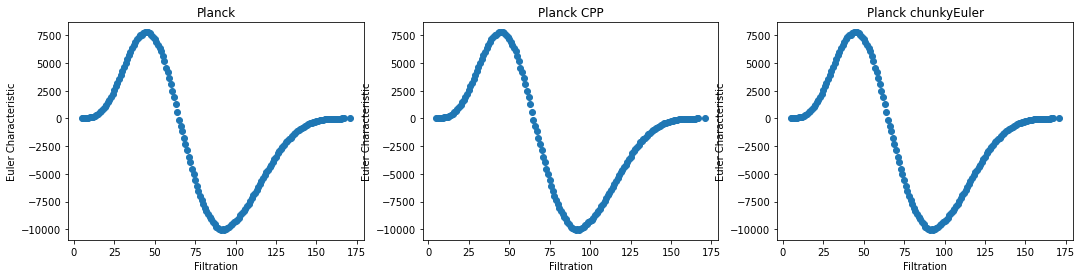

In [17]:
fig, axs = plt.subplots(1, 3, figsize = (18, 4))

im0 = pyecc.plot_euler_curve(ecc_1d, axs[0], with_lines=False)
axs[0].set_title('Planck')

im1 = pyecc.plot_euler_curve(ecc_CPP, axs[1], with_lines=False)
axs[1].set_title('Planck CPP')

im2 = pyecc.plot_euler_curve(ch_ECC, axs[2], with_lines=False)
axs[2].set_title('Planck chunkyEuler')

plt.show()

# Load one RGB image

(480, 374, 3)


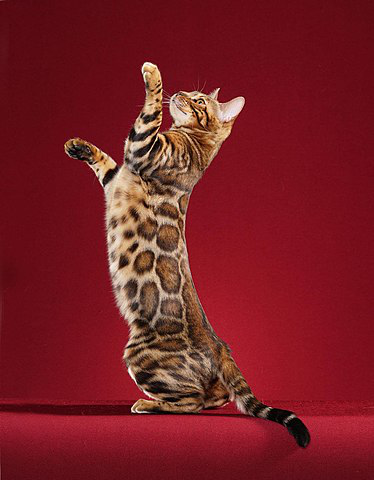

In [18]:
my_image = Image.open("data/bengal.jpg")
my_image_np = np.uint16(my_image)
print(my_image_np.shape)
my_image

In [19]:
%%time
ecp = compute_contributions(my_image_np)

CPU times: user 6.1 s, sys: 56.5 ms, total: 6.16 s
Wall time: 7.42 s


In [20]:
ecp

[((0, 0, 0), 26),
 ((0, 0, 8), 1),
 ((0, 0, 11), -1),
 ((0, 1, 0), 9),
 ((0, 1, 2), 3),
 ((0, 1, 6), -1),
 ((0, 1, 8), -1),
 ((0, 2, 0), 3),
 ((0, 2, 6), 1),
 ((0, 3, 0), 1),
 ((0, 3, 5), 1),
 ((0, 4, 0), 2),
 ((0, 4, 1), 1),
 ((0, 4, 2), -1),
 ((0, 5, 1), -1),
 ((0, 5, 3), 2),
 ((0, 6, 3), 1),
 ((0, 6, 5), -1),
 ((0, 7, 0), -2),
 ((0, 7, 4), 1),
 ((0, 7, 5), 1),
 ((0, 8, 0), -2),
 ((0, 8, 2), -1),
 ((0, 8, 5), -2),
 ((0, 9, 0), -2),
 ((0, 9, 3), 1),
 ((0, 9, 6), -1),
 ((0, 10, 0), 1),
 ((0, 10, 3), -2),
 ((0, 10, 7), 1),
 ((0, 10, 8), -1),
 ((0, 10, 13), 1),
 ((0, 11, 3), 1),
 ((0, 11, 5), -1),
 ((0, 12, 3), -1),
 ((0, 12, 5), 1),
 ((0, 12, 7), -2),
 ((0, 12, 8), 1),
 ((0, 12, 9), -1),
 ((0, 14, 0), -1),
 ((0, 14, 13), -1),
 ((0, 15, 0), -1),
 ((0, 15, 8), -1),
 ((0, 16, 0), -2),
 ((0, 16, 3), 1),
 ((0, 17, 3), -1),
 ((0, 18, 13), 1),
 ((0, 18, 14), -1),
 ((1, 0, 0), 7),
 ((1, 1, 4), 1),
 ((1, 2, 0), 1),
 ((1, 3, 0), 1),
 ((1, 4, 1), 2),
 ((1, 4, 2), -1),
 ((1, 5, 0), 1),
 ((1, 5, 2),